In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns

### Description
Предскажите задержки вылета в 15 и более минут. Известно время вылета, авиакомпания-перевозчик, 
место вылета и назначения, а также расстояние между ними. Прогнозируемый признак – бинарный, целевая метрика – ROC AUC.

#### Признаки:
Month, DayofMonth, DayOfWeek, месяц, день месяца и день недели  
DepTime, время отправления  
UniqueCarrier, код перевозчика  
Origin, место вылета  
Dest, место назначения  
Distance, расстояние между аэропортами вылета и прилета  
dep_delayed_15min, просрочка вылета на 15 и более минут (целевой признак).

In [4]:
train = pd.read_csv(r"C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\flight-delays-2017\flight_delays_train.csv")
test = pd.read_csv(r"C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\flight-delays-2017\flight_delays_test.csv")
sample_submission = pd.read_csv(r"C:\Users\_Lenovo_\PycharmProjects\jupyter_rabota\flight-delays-2017\sample_submission.csv")

In [5]:
initial_shape_train = train.shape
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
initial_shape_test = test.shape
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [7]:
#Проверяем, есть ли в DataFrame пропуски
train.isna().any()

Month                False
DayofMonth           False
DayOfWeek            False
DepTime              False
UniqueCarrier        False
Origin               False
Dest                 False
Distance             False
dep_delayed_15min    False
dtype: bool

В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: DepTime и Distance.

In [8]:
X_train, y_train = (train[["DepTime", "Distance"]].values,
                    train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values,
)
X_test = test[["Distance", "DepTime"]].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=32
)

In [9]:
logit = LogisticRegression(random_state=32)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

In [10]:
roc_auc_score(y_valid, logit_valid_pred)

0.6877344133091989

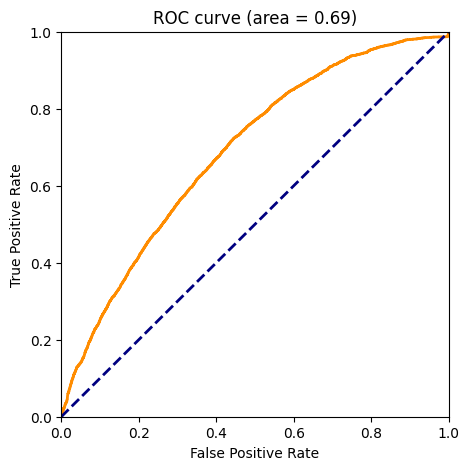

In [11]:
fpr_log, tpr_log, thresholds_log = roc_curve(y_valid, logit_valid_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (area = {:.2f})'.format(roc_auc_score(y_valid, logit_valid_pred)))
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [12]:
# Копируем наши данные для дальнейшей работы, и оригинал данных оставляем неизменными.
X_train_new_features_cat = train.copy()
X_test_new_features_cat = test.copy()

# Создаём новый признак "маршрут" из места вылета в место назначения.
X_train_new_features_cat['Route'] = train['Origin'] + '_' + train['Dest']
X_train_new_features_cat['dep_delayed_15min'] = X_train_new_features_cat['dep_delayed_15min'].map({"Y": 1, "N": 0})
X_test_new_features_cat['Route'] = test['Origin'] + '_' + test['Dest']

In [13]:
# Смотрим на количество номинативных переменных
X_train_new_features_cat.loc[:, X_train_new_features_cat.dtypes == 'object'].nunique()

Month              12
DayofMonth         31
DayOfWeek           7
UniqueCarrier      22
Origin            289
Dest              289
Route            4429
dtype: int64

Далее решаем путём "One-Hot Encoding" видоизменить наши номинативные признаки, все, кроме признака "Route".
Уникальных переменных в признаке "Route" многовато, будем использовать технику кодирования категориальных признаков 
средним значением целевого признака (Mean Target). Основная идея – для каждого значения категориального признака 
посчитать среднее значение целевого признака и заменить категориальный признак на посчитанные средние. 
Правда, считать средние надо на кросс-валидации, а то легко переобучиться.

In [14]:
# Считаем ожидаемое количество признаков, в конце +1 это признак Route
counted_features = (sum(X_train_new_features_cat.drop(['Route'], axis=1).loc[:, X_train_new_features_cat.dtypes == 'object'].
                        nunique().values)
                        + len(X_train_new_features_cat.loc[:, X_train_new_features_cat.dtypes != 'object'].
                              drop(['dep_delayed_15min'], axis=1).nunique().values)+1)
counted_features

653

In [15]:
# Преобразуем номинативные признаки, бинаризация категориальных признаков (One-Hot Encoding).
X_train_new_features = pd.get_dummies(X_train_new_features_cat, columns=['Month','DayofMonth','DayOfWeek','UniqueCarrier','Origin','Dest'])
X_train_new_features.loc[:, X_train_new_features.dtypes == bool] = (X_train_new_features.loc
                                                                [:, X_train_new_features.dtypes == bool].astype(int)
)

In [16]:
# Проверяем если ожидаемое количество признаков совпадает с фактическим
X_train_new_features.drop(['dep_delayed_15min'], axis=1).shape[1] == counted_features

True

In [105]:
# Делим наши данные на test и valid
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
y_train_new_features = X_train_new_features["dep_delayed_15min"]

X_train_new_features_part, X_valid_new_features_part, y_train_new_features_part, y_valid_new_features_part = train_test_split(
    X_train_new_features.drop("dep_delayed_15min", axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)
X_train_new_features_part.shape

(70000, 653)

In [87]:
# Создаём нашу функцию для кодирования номинативных признаков (Mean Target)
def mean_target_enc(train_df, y_train, valid_df, skf):
    import warnings
    warnings.filterwarnings("ignore")
    
    if type(train_df) == pd.core.series.Series:
        train_df = pd.DataFrame({train_df.name : train_df})
    if type(valid_df) == pd.core.series.Series:
        valid_df = pd.DataFrame({valid_df.name : valid_df})
        
    glob_mean = y_train.mean()
    new_train_df = pd.concat([train_df, pd.Series(y_train, name="y")], axis=1)
    cat_features = new_train_df.columns[new_train_df.dtypes == "object"].tolist()

    for col in cat_features:
        new_train_df[col + "_mean_target"] = [
            glob_mean for _ in range(new_train_df.shape[0])
        ]
    
    for col in cat_features:
        means = valid_df[col].map(new_train_df.groupby(col)["y"].mean())
        valid_df[col + "_mean_target"] = means.fillna(glob_mean)
    valid_df.drop(cat_features, axis=1, inplace=True)
   

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = (
            new_train_df.iloc[train_idx, :],
            new_train_df.iloc[valid_idx, :],
        )

        for col in cat_features:
            means = valid_df_cv[col].map(train_df_cv.groupby(col)["y"].mean())
            valid_df_cv[col + "_mean_target"] = means.fillna(glob_mean)

        new_train_df.iloc[valid_idx] = valid_df_cv

    new_train_df.drop(cat_features + ["y"], axis=1, inplace=True)
    return new_train_df, valid_df

In [88]:
# Кодируем с помощью Mean Target только один признак "Route"
train_mean_target_part, valid_mean_target = mean_target_enc(
    X_train_new_features_part["Route"], y_train_new_features_part, X_valid_new_features_part["Route"], skf
)

In [89]:
# Заменяем исходный признак на наш видоизменённый признак
X_train_new_features_part["Route"] = train_mean_target_part
X_valid_new_features_part["Route"] = valid_mean_target

In [21]:
# Проверяем на всякий случай, если ничего не потеряли из признаков, или не добавили как-то
X_train_new_features_part.shape[1] == X_valid_new_features_part.shape[1] == counted_features

True

In [42]:
# Готовим параметры для первой модели "GridSearchCV" с XGBoost
params = {"max_depth": range(4,8), "subsample":[0.6,1], 'reg_lambda': [0.01, 0.1, 1, 10]}
xgb_sklearn_model = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32)

In [27]:
grid_search_cv = GridSearchCV(xgb_sklearn_model, param_grid=params, cv=skf, n_jobs=-1)

In [28]:
%%time
grid_search_cv.fit(X_train_new_features_part, y_train_new_features_part)

CPU times: total: 8min 32s
Wall time: 37min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 8),
                         'reg_lambda': [0.01, 0.1, 1, 10],
                         'subsample': [0.6, 1]})

In [29]:
grid_search_cv.best_params_

{'max_depth': 7, 'reg_lambda': 1, 'subsample': 1}

In [31]:
predicted_xgb = grid_search_cv.best_estimator_.predict_proba(X_valid_new_features_part)
roc_auc_score(y_valid_new_features_part, predicted_xgb[:,1])

0.731843033254146

In [35]:
# Пробуем улучшить модель с помощью лучшего подбора регуляризатора
params_2 = {'reg_lambda': [0.5, 2, 5]}
xgb_sklearn_model_2 = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32
                                 , max_depth=7, subsample=1)

In [36]:
grid_search_cv_2 = GridSearchCV(xgb_sklearn_model_2, param_grid=params_2, cv=skf, n_jobs=-1)

In [37]:
%%time
grid_search_cv_2.fit(X_train_new_features_part, y_train_new_features_part)

CPU times: total: 1min 36s
Wall time: 3min 50s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1, param_grid={'reg_lambda': [0.5, 2, 5]})

In [40]:
grid_search_cv_2.best_params_

{'reg_lambda': 2}

In [41]:
predicted_xgb_2 = grid_search_cv_2.best_estimator_.predict_proba(X_valid_new_features_part)
roc_auc_score(y_valid_new_features_part, predicted_xgb_2[:,1])

0.7335456582849105

Видим что дальнейшая оптимизация регуляризатора не даёт сильного эффекта, пробуем подрезать наши деревья
с помощью регуляризатора "gamma", и посмотрим какой эффект это действие даст.

In [46]:
params_3 = {"gamma":[0.1,0.5,1,5,50]}
xgb_sklearn_model_3 = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32
                                 , max_depth=7, subsample=1, reg_lambda=2)

In [47]:
grid_search_cv_3 = GridSearchCV(xgb_sklearn_model_3, param_grid=params_3, cv=skf, n_jobs=-1)

In [48]:
%%time
grid_search_cv_3.fit(X_train_new_features_part, y_train_new_features_part)

CPU times: total: 2min 4s
Wall time: 5min 31s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=32, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=32, ...),
             n_jobs=-1, param_grid={'gamma': [0.1, 0.5, 1, 5, 50]})

In [49]:
grid_search_cv_3.best_params_

{'gamma': 1}

In [50]:
predicted_xgb_3 = grid_search_cv_3.best_estimator_.predict_proba(X_valid_new_features_part)
roc_auc_score(y_valid_new_features_part, predicted_xgb_3[:,1])

0.7341797877676839

In [43]:
# Итоговые параметры после поисков оптимальных вариантов на "XGBClassifier".
# (n_estimators=50, learning_rate=0.2) ещё нужно оптимизировать
xgb_sklearn_model_final = XGBClassifier(n_estimators=50, learning_rate=0.2, objective="binary:logistic", random_state=32
                                 , max_depth=7, subsample=1, reg_lambda=2, gamma=1)

In [21]:
params_xgb = {
    "booster": "gbtree",
    "max_depth": 7,
    "eta": 0.1,
    "silent": 1,
    "objective": "binary:logistic",
    "nthread": 2,
    "gamma" : 1,
    "lambda" : 2,
    "eval_metric":"auc",
    "seed":32
}
evals_result = {}
dtrain = xgb.DMatrix(X_train_new_features_part, y_train_new_features_part)
dvalid = xgb.DMatrix(X_valid_new_features_part, y_valid_new_features_part)

# По последним данным из списка будет срабатывать 'early_stopping_rounds', ставим 'valid', чтоб избежать переобучения.
watchlist = [(dtrain, "train"), (dvalid, "valid")]

In [22]:
# Ищем оптимальное количество итераций для XGBoost, чтоб оставить меньше шансов для переобучения.
# И для оптимизации работы алгоритма.
%%time
xgb_final = xgb.train(params_xgb, dtrain, num_boost_round=1500, evals = watchlist, 
                      evals_result = evals_result, early_stopping_rounds = 100)

[0]	train-auc:0.71620	valid-auc:0.70089
[1]	train-auc:0.72539	valid-auc:0.70469
[2]	train-auc:0.72801	valid-auc:0.70724
[3]	train-auc:0.72999	valid-auc:0.70773
[4]	train-auc:0.73254	valid-auc:0.70938
[5]	train-auc:0.73451	valid-auc:0.71026
[6]	train-auc:0.73677	valid-auc:0.71184
[7]	train-auc:0.73798	valid-auc:0.71209
[8]	train-auc:0.73906	valid-auc:0.71279
[9]	train-auc:0.74055	valid-auc:0.71366
[10]	train-auc:0.74197	valid-auc:0.71458
[11]	train-auc:0.74318	valid-auc:0.71529
[12]	train-auc:0.74474	valid-auc:0.71630
[13]	train-auc:0.74548	valid-auc:0.71668
[14]	train-auc:0.74651	valid-auc:0.71734
[15]	train-auc:0.74780	valid-auc:0.71797
[16]	train-auc:0.74904	valid-auc:0.71845
[17]	train-auc:0.74995	valid-auc:0.71882
[18]	train-auc:0.75070	valid-auc:0.71938
[19]	train-auc:0.75188	valid-auc:0.72006
[20]	train-auc:0.75268	valid-auc:0.72056
[21]	train-auc:0.75349	valid-auc:0.72108
[22]	train-auc:0.75445	valid-auc:0.72154
[23]	train-auc:0.75573	valid-auc:0.72206
[24]	train-auc:0.75697	val

In [23]:
xgb_best_iteration = xgb_final.best_iteration
xgb_best_iteration

203

In [24]:
evals_result['valid']['auc'][xgb_best_iteration]

0.7378422023738229

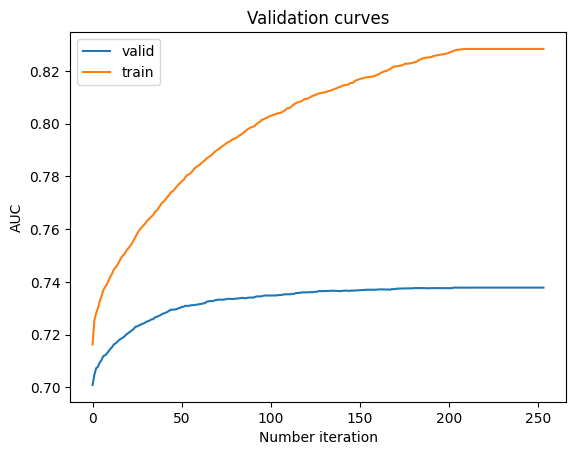

In [87]:
# Строим валидационные кривые, чтоб посмотреть на процесс обучения на train и на test
plt.plot(evals_result['valid']['auc'], label="valid")
plt.plot(evals_result['train']['auc'], label="train")
plt.legend(loc="best")
plt.xlabel('Number iteration')
plt.ylabel('AUC')
plt.title('Validation curves')
plt.show()

In [31]:
# Пробуем использовать алгоритм catboost с параметрами по умолчанию, и без нашего нового признака "Route"
%%time
X_train_new_features_cat_part, X_valid_new_features_cat_part, y_train_new_features_cat_part, y_valid_new_features_cat_part = train_test_split(
    X_train_new_features_cat.drop(["dep_delayed_15min","Route"], axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)

ctb = CatBoostClassifier(random_seed=32)
cat_features_idx = np.where(X_train_new_features_cat_part.dtypes == "object")[0].tolist()
ctb.fit(X_train_new_features_cat_part, y_train_new_features_cat_part, cat_features=cat_features_idx)

Learning rate set to 0.063211
0:	learn: 0.6607142	total: 124ms	remaining: 2m 4s
1:	learn: 0.6322344	total: 312ms	remaining: 2m 35s
2:	learn: 0.6082799	total: 470ms	remaining: 2m 36s
3:	learn: 0.5874889	total: 611ms	remaining: 2m 32s
4:	learn: 0.5686396	total: 838ms	remaining: 2m 46s
5:	learn: 0.5526428	total: 1.04s	remaining: 2m 52s
6:	learn: 0.5401469	total: 1.17s	remaining: 2m 46s
7:	learn: 0.5282146	total: 1.37s	remaining: 2m 50s
8:	learn: 0.5189815	total: 1.5s	remaining: 2m 44s
9:	learn: 0.5101758	total: 1.6s	remaining: 2m 38s
10:	learn: 0.5015514	total: 1.8s	remaining: 2m 41s
11:	learn: 0.4954418	total: 1.97s	remaining: 2m 42s
12:	learn: 0.4892854	total: 2.15s	remaining: 2m 43s
13:	learn: 0.4849753	total: 2.24s	remaining: 2m 38s
14:	learn: 0.4800539	total: 2.44s	remaining: 2m 39s
15:	learn: 0.4756461	total: 2.63s	remaining: 2m 41s
16:	learn: 0.4717573	total: 2.88s	remaining: 2m 46s
17:	learn: 0.4679337	total: 3.1s	remaining: 2m 49s
18:	learn: 0.4649921	total: 3.36s	remaining: 2m 5

159:	learn: 0.4201929	total: 36.5s	remaining: 3m 11s
160:	learn: 0.4201352	total: 36.7s	remaining: 3m 11s
161:	learn: 0.4200327	total: 37s	remaining: 3m 11s
162:	learn: 0.4199717	total: 37.2s	remaining: 3m 10s
163:	learn: 0.4198713	total: 37.4s	remaining: 3m 10s
164:	learn: 0.4198202	total: 37.7s	remaining: 3m 10s
165:	learn: 0.4197623	total: 37.9s	remaining: 3m 10s
166:	learn: 0.4196991	total: 38.1s	remaining: 3m 10s
167:	learn: 0.4195681	total: 38.4s	remaining: 3m 10s
168:	learn: 0.4195034	total: 38.7s	remaining: 3m 10s
169:	learn: 0.4194224	total: 38.9s	remaining: 3m 9s
170:	learn: 0.4192514	total: 39.2s	remaining: 3m 9s
171:	learn: 0.4191165	total: 39.4s	remaining: 3m 9s
172:	learn: 0.4190227	total: 39.6s	remaining: 3m 9s
173:	learn: 0.4189656	total: 39.9s	remaining: 3m 9s
174:	learn: 0.4189018	total: 40.1s	remaining: 3m 9s
175:	learn: 0.4188282	total: 40.4s	remaining: 3m 9s
176:	learn: 0.4187864	total: 40.7s	remaining: 3m 9s
177:	learn: 0.4187046	total: 41s	remaining: 3m 9s
178:	l

316:	learn: 0.4099829	total: 1m 17s	remaining: 2m 46s
317:	learn: 0.4099417	total: 1m 17s	remaining: 2m 45s
318:	learn: 0.4099078	total: 1m 17s	remaining: 2m 45s
319:	learn: 0.4098492	total: 1m 17s	remaining: 2m 45s
320:	learn: 0.4097964	total: 1m 18s	remaining: 2m 45s
321:	learn: 0.4097475	total: 1m 18s	remaining: 2m 44s
322:	learn: 0.4097002	total: 1m 18s	remaining: 2m 44s
323:	learn: 0.4096573	total: 1m 18s	remaining: 2m 44s
324:	learn: 0.4095980	total: 1m 19s	remaining: 2m 44s
325:	learn: 0.4095581	total: 1m 19s	remaining: 2m 44s
326:	learn: 0.4095148	total: 1m 19s	remaining: 2m 43s
327:	learn: 0.4094923	total: 1m 19s	remaining: 2m 43s
328:	learn: 0.4094346	total: 1m 20s	remaining: 2m 43s
329:	learn: 0.4094081	total: 1m 20s	remaining: 2m 43s
330:	learn: 0.4093828	total: 1m 20s	remaining: 2m 43s
331:	learn: 0.4093515	total: 1m 21s	remaining: 2m 43s
332:	learn: 0.4093266	total: 1m 21s	remaining: 2m 43s
333:	learn: 0.4092828	total: 1m 21s	remaining: 2m 42s
334:	learn: 0.4092502	total:

468:	learn: 0.4038977	total: 1m 56s	remaining: 2m 12s
469:	learn: 0.4038455	total: 1m 57s	remaining: 2m 12s
470:	learn: 0.4038164	total: 1m 57s	remaining: 2m 11s
471:	learn: 0.4037916	total: 1m 57s	remaining: 2m 11s
472:	learn: 0.4037819	total: 1m 57s	remaining: 2m 11s
473:	learn: 0.4036957	total: 1m 58s	remaining: 2m 11s
474:	learn: 0.4036418	total: 1m 58s	remaining: 2m 11s
475:	learn: 0.4035996	total: 1m 58s	remaining: 2m 10s
476:	learn: 0.4035819	total: 1m 59s	remaining: 2m 10s
477:	learn: 0.4035198	total: 1m 59s	remaining: 2m 10s
478:	learn: 0.4035101	total: 1m 59s	remaining: 2m 9s
479:	learn: 0.4034567	total: 1m 59s	remaining: 2m 9s
480:	learn: 0.4034158	total: 1m 59s	remaining: 2m 9s
481:	learn: 0.4033913	total: 2m	remaining: 2m 9s
482:	learn: 0.4033614	total: 2m	remaining: 2m 8s
483:	learn: 0.4033269	total: 2m	remaining: 2m 8s
484:	learn: 0.4033031	total: 2m 1s	remaining: 2m 8s
485:	learn: 0.4032740	total: 2m 1s	remaining: 2m 8s
486:	learn: 0.4032157	total: 2m 1s	remaining: 2m 8

622:	learn: 0.3983727	total: 2m 37s	remaining: 1m 35s
623:	learn: 0.3983493	total: 2m 38s	remaining: 1m 35s
624:	learn: 0.3982980	total: 2m 38s	remaining: 1m 35s
625:	learn: 0.3982801	total: 2m 38s	remaining: 1m 34s
626:	learn: 0.3982541	total: 2m 39s	remaining: 1m 34s
627:	learn: 0.3982434	total: 2m 39s	remaining: 1m 34s
628:	learn: 0.3982218	total: 2m 39s	remaining: 1m 34s
629:	learn: 0.3982118	total: 2m 39s	remaining: 1m 33s
630:	learn: 0.3981494	total: 2m 40s	remaining: 1m 33s
631:	learn: 0.3980871	total: 2m 40s	remaining: 1m 33s
632:	learn: 0.3980392	total: 2m 40s	remaining: 1m 33s
633:	learn: 0.3980107	total: 2m 40s	remaining: 1m 32s
634:	learn: 0.3979904	total: 2m 41s	remaining: 1m 32s
635:	learn: 0.3979736	total: 2m 41s	remaining: 1m 32s
636:	learn: 0.3979647	total: 2m 41s	remaining: 1m 32s
637:	learn: 0.3979265	total: 2m 41s	remaining: 1m 31s
638:	learn: 0.3978945	total: 2m 42s	remaining: 1m 31s
639:	learn: 0.3978828	total: 2m 42s	remaining: 1m 31s
640:	learn: 0.3978417	total:

776:	learn: 0.3935629	total: 3m 20s	remaining: 57.6s
777:	learn: 0.3935462	total: 3m 20s	remaining: 57.3s
778:	learn: 0.3935215	total: 3m 21s	remaining: 57.1s
779:	learn: 0.3935048	total: 3m 21s	remaining: 56.8s
780:	learn: 0.3934786	total: 3m 21s	remaining: 56.6s
781:	learn: 0.3934439	total: 3m 21s	remaining: 56.3s
782:	learn: 0.3934082	total: 3m 22s	remaining: 56s
783:	learn: 0.3933689	total: 3m 22s	remaining: 55.8s
784:	learn: 0.3933351	total: 3m 22s	remaining: 55.5s
785:	learn: 0.3933159	total: 3m 23s	remaining: 55.3s
786:	learn: 0.3932760	total: 3m 23s	remaining: 55s
787:	learn: 0.3932183	total: 3m 23s	remaining: 54.8s
788:	learn: 0.3931972	total: 3m 23s	remaining: 54.5s
789:	learn: 0.3931758	total: 3m 24s	remaining: 54.3s
790:	learn: 0.3931545	total: 3m 24s	remaining: 54s
791:	learn: 0.3931236	total: 3m 24s	remaining: 53.8s
792:	learn: 0.3930813	total: 3m 25s	remaining: 53.6s
793:	learn: 0.3930333	total: 3m 26s	remaining: 53.5s
794:	learn: 0.3929861	total: 3m 26s	remaining: 53.3s

933:	learn: 0.3885683	total: 4m 11s	remaining: 17.8s
934:	learn: 0.3885227	total: 4m 11s	remaining: 17.5s
935:	learn: 0.3885054	total: 4m 12s	remaining: 17.3s
936:	learn: 0.3884842	total: 4m 12s	remaining: 17s
937:	learn: 0.3884191	total: 4m 13s	remaining: 16.8s
938:	learn: 0.3883816	total: 4m 14s	remaining: 16.5s
939:	learn: 0.3883601	total: 4m 14s	remaining: 16.2s
940:	learn: 0.3883104	total: 4m 14s	remaining: 16s
941:	learn: 0.3882853	total: 4m 15s	remaining: 15.7s
942:	learn: 0.3882604	total: 4m 15s	remaining: 15.5s
943:	learn: 0.3881930	total: 4m 16s	remaining: 15.2s
944:	learn: 0.3881605	total: 4m 16s	remaining: 14.9s
945:	learn: 0.3881149	total: 4m 17s	remaining: 14.7s
946:	learn: 0.3880897	total: 4m 17s	remaining: 14.4s
947:	learn: 0.3880759	total: 4m 17s	remaining: 14.1s
948:	learn: 0.3880445	total: 4m 18s	remaining: 13.9s
949:	learn: 0.3880086	total: 4m 18s	remaining: 13.6s
950:	learn: 0.3879725	total: 4m 19s	remaining: 13.4s
951:	learn: 0.3879343	total: 4m 19s	remaining: 13.

In [38]:
# Видим что catboost с параметрами с коробки справляется лучше чем XGBoost, но время на обучение занимает больше
roc_auc_score(y_valid_new_features_cat_part, ctb.predict_proba(X_valid_new_features_cat_part)[:, 1])

0.7603582548157578

In [154]:
# Пробуем теперь с нашим новым параметром "Route", и при этом меняем только его через параметр "cat_features"
%%time
(X_train_new_features_cat_part_2, X_valid_new_features_cat_part_2, 
y_train_new_features_cat_part_2, y_valid_new_features_cat_part_2) = train_test_split(
    X_train_new_features.drop("dep_delayed_15min", axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)
ctb_2 = CatBoostClassifier(random_seed=32)
cat_features_idx_2 = np.where(X_train_new_features_cat_part_2.columns == "Route")[0].tolist()
ctb_2.fit(X_train_new_features_cat_part_2, y_train_new_features_cat_part_2, cat_features=cat_features_idx_2)

Learning rate set to 0.063211
0:	learn: 0.6594570	total: 166ms	remaining: 2m 45s
1:	learn: 0.6304986	total: 324ms	remaining: 2m 41s
2:	learn: 0.6065101	total: 482ms	remaining: 2m 40s
3:	learn: 0.5851682	total: 629ms	remaining: 2m 36s
4:	learn: 0.5670236	total: 786ms	remaining: 2m 36s
5:	learn: 0.5510926	total: 932ms	remaining: 2m 34s
6:	learn: 0.5385897	total: 1.09s	remaining: 2m 34s
7:	learn: 0.5271549	total: 1.24s	remaining: 2m 33s
8:	learn: 0.5162907	total: 1.4s	remaining: 2m 34s
9:	learn: 0.5078539	total: 1.54s	remaining: 2m 32s
10:	learn: 0.5006215	total: 1.7s	remaining: 2m 33s
11:	learn: 0.4938059	total: 1.85s	remaining: 2m 32s
12:	learn: 0.4884362	total: 2.01s	remaining: 2m 32s
13:	learn: 0.4830908	total: 2.16s	remaining: 2m 32s
14:	learn: 0.4786566	total: 2.32s	remaining: 2m 32s
15:	learn: 0.4745685	total: 2.47s	remaining: 2m 32s
16:	learn: 0.4708777	total: 2.63s	remaining: 2m 32s
17:	learn: 0.4681299	total: 2.77s	remaining: 2m 31s
18:	learn: 0.4655826	total: 2.94s	remaining: 2

158:	learn: 0.4265328	total: 24.5s	remaining: 2m 9s
159:	learn: 0.4264447	total: 24.6s	remaining: 2m 9s
160:	learn: 0.4263565	total: 24.8s	remaining: 2m 9s
161:	learn: 0.4262733	total: 24.9s	remaining: 2m 9s
162:	learn: 0.4261738	total: 25.1s	remaining: 2m 8s
163:	learn: 0.4260927	total: 25.3s	remaining: 2m 8s
164:	learn: 0.4260077	total: 25.4s	remaining: 2m 8s
165:	learn: 0.4258873	total: 25.6s	remaining: 2m 8s
166:	learn: 0.4258296	total: 25.7s	remaining: 2m 8s
167:	learn: 0.4257890	total: 25.9s	remaining: 2m 8s
168:	learn: 0.4257173	total: 26.1s	remaining: 2m 8s
169:	learn: 0.4256417	total: 26.2s	remaining: 2m 7s
170:	learn: 0.4255493	total: 26.4s	remaining: 2m 7s
171:	learn: 0.4254544	total: 26.5s	remaining: 2m 7s
172:	learn: 0.4253510	total: 26.7s	remaining: 2m 7s
173:	learn: 0.4252512	total: 26.8s	remaining: 2m 7s
174:	learn: 0.4251521	total: 27s	remaining: 2m 7s
175:	learn: 0.4250213	total: 27.1s	remaining: 2m 7s
176:	learn: 0.4249338	total: 27.3s	remaining: 2m 6s
177:	learn: 0.

316:	learn: 0.4135862	total: 49.5s	remaining: 1m 46s
317:	learn: 0.4134882	total: 49.7s	remaining: 1m 46s
318:	learn: 0.4134674	total: 49.8s	remaining: 1m 46s
319:	learn: 0.4134083	total: 50s	remaining: 1m 46s
320:	learn: 0.4133488	total: 50.1s	remaining: 1m 46s
321:	learn: 0.4132863	total: 50.3s	remaining: 1m 45s
322:	learn: 0.4132350	total: 50.5s	remaining: 1m 45s
323:	learn: 0.4132277	total: 50.6s	remaining: 1m 45s
324:	learn: 0.4131712	total: 50.8s	remaining: 1m 45s
325:	learn: 0.4131306	total: 50.9s	remaining: 1m 45s
326:	learn: 0.4130745	total: 51.1s	remaining: 1m 45s
327:	learn: 0.4130143	total: 51.2s	remaining: 1m 44s
328:	learn: 0.4129342	total: 51.4s	remaining: 1m 44s
329:	learn: 0.4128740	total: 51.5s	remaining: 1m 44s
330:	learn: 0.4128171	total: 51.7s	remaining: 1m 44s
331:	learn: 0.4127548	total: 51.9s	remaining: 1m 44s
332:	learn: 0.4126647	total: 52s	remaining: 1m 44s
333:	learn: 0.4125808	total: 52.2s	remaining: 1m 44s
334:	learn: 0.4125705	total: 52.4s	remaining: 1m 4

471:	learn: 0.4052627	total: 1m 14s	remaining: 1m 23s
472:	learn: 0.4052164	total: 1m 15s	remaining: 1m 23s
473:	learn: 0.4051566	total: 1m 15s	remaining: 1m 23s
474:	learn: 0.4050629	total: 1m 15s	remaining: 1m 23s
475:	learn: 0.4049982	total: 1m 15s	remaining: 1m 23s
476:	learn: 0.4049358	total: 1m 15s	remaining: 1m 22s
477:	learn: 0.4048899	total: 1m 15s	remaining: 1m 22s
478:	learn: 0.4048362	total: 1m 15s	remaining: 1m 22s
479:	learn: 0.4047869	total: 1m 16s	remaining: 1m 22s
480:	learn: 0.4047790	total: 1m 16s	remaining: 1m 22s
481:	learn: 0.4047129	total: 1m 16s	remaining: 1m 22s
482:	learn: 0.4046439	total: 1m 16s	remaining: 1m 22s
483:	learn: 0.4045743	total: 1m 16s	remaining: 1m 21s
484:	learn: 0.4045203	total: 1m 16s	remaining: 1m 21s
485:	learn: 0.4044508	total: 1m 17s	remaining: 1m 21s
486:	learn: 0.4044030	total: 1m 17s	remaining: 1m 21s
487:	learn: 0.4043415	total: 1m 17s	remaining: 1m 21s
488:	learn: 0.4042910	total: 1m 17s	remaining: 1m 21s
489:	learn: 0.4042673	total:

625:	learn: 0.3983741	total: 1m 40s	remaining: 60s
626:	learn: 0.3983323	total: 1m 40s	remaining: 59.8s
627:	learn: 0.3982610	total: 1m 40s	remaining: 59.7s
628:	learn: 0.3982238	total: 1m 40s	remaining: 59.5s
629:	learn: 0.3981793	total: 1m 41s	remaining: 59.4s
630:	learn: 0.3981369	total: 1m 41s	remaining: 59.2s
631:	learn: 0.3980550	total: 1m 41s	remaining: 59s
632:	learn: 0.3980108	total: 1m 41s	remaining: 58.9s
633:	learn: 0.3979542	total: 1m 41s	remaining: 58.7s
634:	learn: 0.3979498	total: 1m 41s	remaining: 58.6s
635:	learn: 0.3979078	total: 1m 42s	remaining: 58.4s
636:	learn: 0.3979001	total: 1m 42s	remaining: 58.3s
637:	learn: 0.3978520	total: 1m 42s	remaining: 58.1s
638:	learn: 0.3977998	total: 1m 42s	remaining: 58s
639:	learn: 0.3977769	total: 1m 42s	remaining: 57.8s
640:	learn: 0.3977308	total: 1m 42s	remaining: 57.7s
641:	learn: 0.3976795	total: 1m 43s	remaining: 57.5s
642:	learn: 0.3976150	total: 1m 43s	remaining: 57.3s
643:	learn: 0.3975992	total: 1m 43s	remaining: 57.2s

783:	learn: 0.3919394	total: 2m 7s	remaining: 35s
784:	learn: 0.3919093	total: 2m 7s	remaining: 34.9s
785:	learn: 0.3918891	total: 2m 7s	remaining: 34.7s
786:	learn: 0.3918408	total: 2m 7s	remaining: 34.5s
787:	learn: 0.3918165	total: 2m 7s	remaining: 34.4s
788:	learn: 0.3918052	total: 2m 7s	remaining: 34.2s
789:	learn: 0.3917553	total: 2m 8s	remaining: 34.1s
790:	learn: 0.3916849	total: 2m 8s	remaining: 33.9s
791:	learn: 0.3916395	total: 2m 8s	remaining: 33.7s
792:	learn: 0.3916159	total: 2m 8s	remaining: 33.6s
793:	learn: 0.3915698	total: 2m 8s	remaining: 33.4s
794:	learn: 0.3915581	total: 2m 8s	remaining: 33.3s
795:	learn: 0.3915279	total: 2m 9s	remaining: 33.1s
796:	learn: 0.3915022	total: 2m 9s	remaining: 32.9s
797:	learn: 0.3914585	total: 2m 9s	remaining: 32.8s
798:	learn: 0.3914279	total: 2m 9s	remaining: 32.6s
799:	learn: 0.3913812	total: 2m 9s	remaining: 32.4s
800:	learn: 0.3913214	total: 2m 9s	remaining: 32.3s
801:	learn: 0.3912423	total: 2m 10s	remaining: 32.1s
802:	learn: 0

939:	learn: 0.3864441	total: 2m 33s	remaining: 9.81s
940:	learn: 0.3863789	total: 2m 33s	remaining: 9.64s
941:	learn: 0.3863488	total: 2m 33s	remaining: 9.48s
942:	learn: 0.3863415	total: 2m 34s	remaining: 9.32s
943:	learn: 0.3863028	total: 2m 34s	remaining: 9.15s
944:	learn: 0.3862564	total: 2m 34s	remaining: 8.99s
945:	learn: 0.3862116	total: 2m 34s	remaining: 8.83s
946:	learn: 0.3861826	total: 2m 34s	remaining: 8.66s
947:	learn: 0.3861387	total: 2m 35s	remaining: 8.5s
948:	learn: 0.3860957	total: 2m 35s	remaining: 8.34s
949:	learn: 0.3860435	total: 2m 35s	remaining: 8.18s
950:	learn: 0.3859963	total: 2m 35s	remaining: 8.01s
951:	learn: 0.3859585	total: 2m 35s	remaining: 7.85s
952:	learn: 0.3859075	total: 2m 35s	remaining: 7.69s
953:	learn: 0.3858846	total: 2m 36s	remaining: 7.52s
954:	learn: 0.3858405	total: 2m 36s	remaining: 7.36s
955:	learn: 0.3858370	total: 2m 36s	remaining: 7.2s
956:	learn: 0.3858259	total: 2m 36s	remaining: 7.03s
957:	learn: 0.3858043	total: 2m 36s	remaining: 6

In [155]:
# Стало хуже
roc_auc_score(y_valid_new_features_cat_part_2, ctb_2.predict_proba(X_valid_new_features_cat_part_2)[:, 1])

0.7451408769385925

In [41]:
# Теперь пробуем вместе с "Route" и при этом все категориальные признаки пропустить через параметр "cat_features"
%%time
(X_train_new_features_cat_part_3, X_valid_new_features_cat_part_3, 
y_train_new_features_cat_part_3, y_valid_new_features_cat_part_3) = train_test_split(
    X_train_new_features_cat.drop("dep_delayed_15min", axis=1),
    y_train_new_features,
    test_size=0.3,
    stratify=y_train_new_features,
    random_state=32
)

ctb_3 = CatBoostClassifier(random_seed=32)
cat_features_idx_3 = np.where(X_train_new_features_cat_part_3.dtypes == "object")[0].tolist()
ctb_3.fit(X_train_new_features_cat_part_3, y_train_new_features_cat_part_3, cat_features=cat_features_idx_3)

CPU times: total: 109 ms
Wall time: 115 ms


In [26]:
# Пока лучший результат
roc_auc_score(y_valid_new_features_cat_part_3, ctb_3.predict_proba(X_valid_new_features_cat_part_3)[:, 1])

0.762890080910112

In [68]:
ctb_3_feature_importances = pd.DataFrame(ctb_3.feature_importances_, index=ctb_3.feature_names_, 
                                         columns=['feature_importances']).sort_values('feature_importances', 
                                                                                      ascending=False)
ctb_3_feature_importances

,feature_importances
DepTime,40.036483
UniqueCarrier,10.706679
Dest,8.282542
Origin,7.976791
Month,7.627197
Distance,7.178618
DayofMonth,6.699023
Route,5.944334
DayOfWeek,5.548331


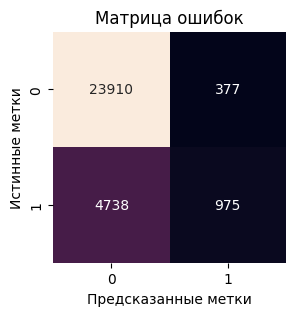

4738

In [113]:
conf_mat = confusion_matrix(y_valid_new_features_cat_part_3, ctb_3.predict(X_valid_new_features_cat_part_3))
plt.figure(figsize=[3,3])
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

In [109]:
np.bincount(y_train)

array([80956, 19044], dtype=int64)

In [35]:
# Видим что наш алгоритм предсказываем гораздо хуже классы 1, пробуем улучшить ситуацию с помощью весов для модели
# И срзу оптимизируем алгоритм по количеству итераций
%%time
eval_set = (X_valid_new_features_cat_part_3, y_valid_new_features_cat_part_3)
ctb_4 = CatBoostClassifier(random_seed=32, auto_class_weights='Balanced', early_stopping_rounds=100, eval_metric="AUC", 
                           metric_period=100, iterations=2000)
ctb_4.fit(X_train_new_features_cat_part_3, y_train_new_features_cat_part_3, cat_features=cat_features_idx_3, 
          eval_set=eval_set)

Learning rate set to 0.066942


0:	test: 0.6930752	best: 0.6930752 (0)	total: 545ms	remaining: 18m 9s
100:	test: 0.7428542	best: 0.7428584 (99)	total: 28.9s	remaining: 9m 3s
200:	test: 0.7495258	best: 0.7495565 (199)	total: 59.9s	remaining: 8m 56s
300:	test: 0.7537098	best: 0.7537098 (300)	total: 1m 33s	remaining: 8m 45s
400:	test: 0.7566591	best: 0.7567061 (396)	total: 2m 8s	remaining: 8m 31s
500:	test: 0.7584294	best: 0.7584294 (500)	total: 2m 44s	remaining: 8m 11s
600:	test: 0.7592919	best: 0.7593222 (595)	total: 3m 20s	remaining: 7m 47s
700:	test: 0.7607611	best: 0.7607611 (700)	total: 3m 58s	remaining: 7m 22s
800:	test: 0.7618305	best: 0.7619444 (783)	total: 4m 37s	remaining: 6m 55s
900:	test: 0.7622839	best: 0.7622839 (900)	total: 5m 17s	remaining: 6m 26s
1000:	test: 0.7625588	best: 0.7625588 (1000)	total: 5m 54s	remaining: 5m 53s
1100:	test: 0.7630789	best: 0.7630789 (1100)	total: 6m 36s	remaining: 5m 23s
1200:	test: 0.7635776	best: 0.7636547 (1192)	total: 7m 17s	remaining: 4m 51s
1300:	test: 0.7642503	best: 0

In [38]:
# Наш лучший результат
ctb_valid_predict = ctb_4.predict_proba(X_valid_new_features_cat_part_3)[:, 1]
roc_auc_score(y_valid_new_features_cat_part_3, ctb_valid_predict)

0.7646270406724084

In [151]:
# Видим что важность наших признаков более равномерней распределилась
ctb_4_feature_importances = pd.DataFrame(ctb_4.feature_importances_, index=ctb_4.feature_names_, 
                                         columns=['feature_importances']).sort_values('feature_importances', 
                                                                                      ascending=False)
ctb_4_feature_importances

,feature_importances
DepTime,30.119665
UniqueCarrier,10.955977
Dest,9.607299
Origin,9.519609
Distance,9.241380
Route,9.102014
Month,7.612624
DayofMonth,7.071274
DayOfWeek,6.770159


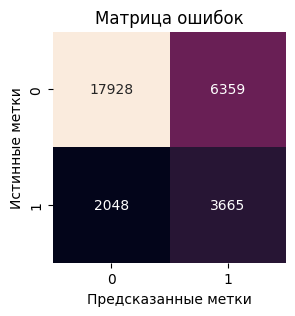

In [152]:
# И мы лучше начали предсказывать классы 1, чуть хуже классы 0 чем было.
# Но наш главный оптимизационный критерий "AUC" не пострадал, а только чуть прибавился.
conf_mat = confusion_matrix(y_valid_new_features_cat_part_3, ctb_4.predict(X_valid_new_features_cat_part_3))
plt.figure(figsize=[3,3])
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

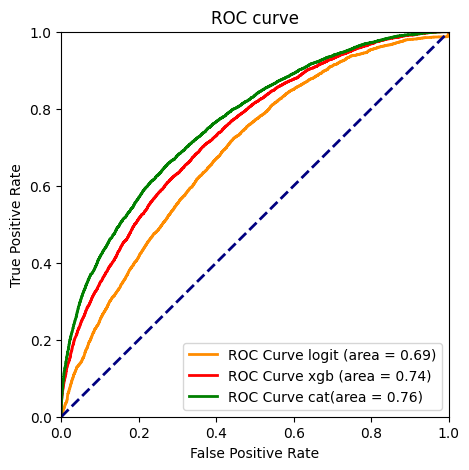

In [43]:
# Строим ROC-AUC для всех наших моделей
xgb_valid_predict = xgb_final.predict(dvalid)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_valid_new_features_part, xgb_valid_predict)
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_valid_new_features_cat_part_3, ctb_valid_predict)
plt.figure(figsize=(5, 5))
plt.plot(fpr_log, tpr_log, color='darkorange', lw=2, label="ROC Curve logit (area = {:.2f})".
         format(roc_auc_score(y_valid, logit_valid_pred)))
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label="ROC Curve xgb (area = {:.2f})".
         format(roc_auc_score(y_valid_new_features_part, xgb_valid_predict)))
plt.plot(fpr_cat, tpr_cat, color='green', lw=2, label="ROC Curve cat(area = {:.2f})".
         format(roc_auc_score(y_valid_new_features_cat_part_3, ctb_valid_predict)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="best")
plt.show()

In [154]:
ctb_4_best_iteration = ctb_4.best_iteration_
ctb_4_best_iteration

1382

In [155]:
# Обучаем самый последний алгоритм для всех наших train данных, чтоб спрогнозировать test данные и отправить на Kaggle
ctb_final = CatBoostClassifier(random_seed=32, auto_class_weights='Balanced', iterations=ctb_4_best_iteration)
ctb_final.fit(X_train_new_features_cat.drop("dep_delayed_15min", axis=1), y_train, 
              cat_features=cat_features_idx_3)
result = ctb_final.predict_proba(X_test_new_features_cat)[:, 1]

Learning rate set to 0.054067
0:	learn: 0.6867545	total: 408ms	remaining: 9m 31s
1:	learn: 0.6816048	total: 760ms	remaining: 8m 51s
2:	learn: 0.6758248	total: 1.12s	remaining: 8m 39s
3:	learn: 0.6707279	total: 1.43s	remaining: 8m 20s
4:	learn: 0.6669674	total: 1.77s	remaining: 8m 13s
5:	learn: 0.6634891	total: 2.14s	remaining: 8m 17s
6:	learn: 0.6593269	total: 2.48s	remaining: 8m 13s
7:	learn: 0.6560589	total: 2.9s	remaining: 8m 25s
8:	learn: 0.6521580	total: 3.27s	remaining: 8m 24s
9:	learn: 0.6495130	total: 3.6s	remaining: 8m 20s
10:	learn: 0.6469275	total: 3.99s	remaining: 8m 24s
11:	learn: 0.6446382	total: 4.39s	remaining: 8m 28s
12:	learn: 0.6426297	total: 4.64s	remaining: 8m 15s
13:	learn: 0.6407989	total: 5.01s	remaining: 8m 16s
14:	learn: 0.6389767	total: 5.35s	remaining: 8m 14s
15:	learn: 0.6365877	total: 5.77s	remaining: 8m 19s
16:	learn: 0.6347327	total: 6.16s	remaining: 8m 21s
17:	learn: 0.6328276	total: 6.59s	remaining: 8m 25s
18:	learn: 0.6312060	total: 6.98s	remaining: 8

158:	learn: 0.5890639	total: 58.5s	remaining: 7m 36s
159:	learn: 0.5889137	total: 58.8s	remaining: 7m 36s
160:	learn: 0.5887747	total: 59.2s	remaining: 7m 35s
161:	learn: 0.5886201	total: 59.6s	remaining: 7m 35s
162:	learn: 0.5885687	total: 60s	remaining: 7m 35s
163:	learn: 0.5885314	total: 1m	remaining: 7m 34s
164:	learn: 0.5884781	total: 1m	remaining: 7m 34s
165:	learn: 0.5884278	total: 1m 1s	remaining: 7m 34s
166:	learn: 0.5883483	total: 1m 1s	remaining: 7m 34s
167:	learn: 0.5881978	total: 1m 1s	remaining: 7m 34s
168:	learn: 0.5881783	total: 1m 2s	remaining: 7m 34s
169:	learn: 0.5880903	total: 1m 2s	remaining: 7m 33s
170:	learn: 0.5879990	total: 1m 2s	remaining: 7m 32s
171:	learn: 0.5878790	total: 1m 3s	remaining: 7m 32s
172:	learn: 0.5877762	total: 1m 3s	remaining: 7m 32s
173:	learn: 0.5877080	total: 1m 4s	remaining: 7m 31s
174:	learn: 0.5876471	total: 1m 4s	remaining: 7m 31s
175:	learn: 0.5875679	total: 1m 4s	remaining: 7m 31s
176:	learn: 0.5875193	total: 1m 5s	remaining: 7m 30s
1

311:	learn: 0.5765719	total: 2m 14s	remaining: 7m 47s
312:	learn: 0.5765216	total: 2m 14s	remaining: 7m 47s
313:	learn: 0.5764155	total: 2m 14s	remaining: 7m 46s
314:	learn: 0.5763394	total: 2m 15s	remaining: 7m 46s
315:	learn: 0.5762897	total: 2m 15s	remaining: 7m 45s
316:	learn: 0.5762186	total: 2m 16s	remaining: 7m 45s
317:	learn: 0.5761772	total: 2m 16s	remaining: 7m 45s
318:	learn: 0.5761148	total: 2m 17s	remaining: 7m 44s
319:	learn: 0.5760694	total: 2m 17s	remaining: 7m 44s
320:	learn: 0.5760272	total: 2m 17s	remaining: 7m 43s
321:	learn: 0.5759566	total: 2m 18s	remaining: 7m 43s
322:	learn: 0.5759035	total: 2m 18s	remaining: 7m 42s
323:	learn: 0.5758322	total: 2m 19s	remaining: 7m 42s
324:	learn: 0.5757925	total: 2m 19s	remaining: 7m 41s
325:	learn: 0.5757373	total: 2m 20s	remaining: 7m 41s
326:	learn: 0.5756736	total: 2m 20s	remaining: 7m 41s
327:	learn: 0.5756256	total: 2m 20s	remaining: 7m 40s
328:	learn: 0.5755802	total: 2m 21s	remaining: 7m 40s
329:	learn: 0.5754976	total:

464:	learn: 0.5677639	total: 3m 23s	remaining: 6m 48s
465:	learn: 0.5676566	total: 3m 23s	remaining: 6m 47s
466:	learn: 0.5676076	total: 3m 23s	remaining: 6m 47s
467:	learn: 0.5675340	total: 3m 24s	remaining: 6m 47s
468:	learn: 0.5674722	total: 3m 25s	remaining: 6m 47s
469:	learn: 0.5674276	total: 3m 25s	remaining: 6m 46s
470:	learn: 0.5674054	total: 3m 25s	remaining: 6m 46s
471:	learn: 0.5673640	total: 3m 26s	remaining: 6m 45s
472:	learn: 0.5673336	total: 3m 26s	remaining: 6m 45s
473:	learn: 0.5673063	total: 3m 27s	remaining: 6m 44s
474:	learn: 0.5672644	total: 3m 27s	remaining: 6m 43s
475:	learn: 0.5671689	total: 3m 27s	remaining: 6m 43s
476:	learn: 0.5671354	total: 3m 28s	remaining: 6m 42s
477:	learn: 0.5671049	total: 3m 28s	remaining: 6m 42s
478:	learn: 0.5670418	total: 3m 29s	remaining: 6m 42s
479:	learn: 0.5670186	total: 3m 29s	remaining: 6m 41s
480:	learn: 0.5669516	total: 3m 29s	remaining: 6m 41s
481:	learn: 0.5669061	total: 3m 30s	remaining: 6m 40s
482:	learn: 0.5668745	total:

617:	learn: 0.5602146	total: 4m 31s	remaining: 5m 43s
618:	learn: 0.5599979	total: 4m 31s	remaining: 5m 42s
619:	learn: 0.5599307	total: 4m 32s	remaining: 5m 42s
620:	learn: 0.5599039	total: 4m 32s	remaining: 5m 42s
621:	learn: 0.5598612	total: 4m 33s	remaining: 5m 41s
622:	learn: 0.5597904	total: 4m 33s	remaining: 5m 41s
623:	learn: 0.5597471	total: 4m 34s	remaining: 5m 40s
624:	learn: 0.5596948	total: 4m 34s	remaining: 5m 40s
625:	learn: 0.5596640	total: 4m 35s	remaining: 5m 40s
626:	learn: 0.5596368	total: 4m 35s	remaining: 5m 39s
627:	learn: 0.5595605	total: 4m 36s	remaining: 5m 39s
628:	learn: 0.5595222	total: 4m 36s	remaining: 5m 39s
629:	learn: 0.5595040	total: 4m 36s	remaining: 5m 38s
630:	learn: 0.5594611	total: 4m 37s	remaining: 5m 38s
631:	learn: 0.5594224	total: 4m 37s	remaining: 5m 37s
632:	learn: 0.5594089	total: 4m 38s	remaining: 5m 37s
633:	learn: 0.5593702	total: 4m 38s	remaining: 5m 36s
634:	learn: 0.5593166	total: 4m 39s	remaining: 5m 36s
635:	learn: 0.5593051	total:

770:	learn: 0.5531731	total: 5m 44s	remaining: 4m 40s
771:	learn: 0.5531393	total: 5m 44s	remaining: 4m 40s
772:	learn: 0.5531119	total: 5m 44s	remaining: 4m 39s
773:	learn: 0.5530658	total: 5m 45s	remaining: 4m 39s
774:	learn: 0.5530394	total: 5m 45s	remaining: 4m 38s
775:	learn: 0.5529928	total: 5m 46s	remaining: 4m 38s
776:	learn: 0.5529562	total: 5m 46s	remaining: 4m 37s
777:	learn: 0.5528951	total: 5m 47s	remaining: 4m 37s
778:	learn: 0.5528109	total: 5m 47s	remaining: 4m 37s
779:	learn: 0.5527728	total: 5m 47s	remaining: 4m 36s
780:	learn: 0.5527320	total: 5m 48s	remaining: 4m 36s
781:	learn: 0.5527059	total: 5m 49s	remaining: 4m 35s
782:	learn: 0.5526880	total: 5m 49s	remaining: 4m 35s
783:	learn: 0.5526571	total: 5m 49s	remaining: 4m 34s
784:	learn: 0.5526046	total: 5m 50s	remaining: 4m 34s
785:	learn: 0.5525718	total: 5m 50s	remaining: 4m 34s
786:	learn: 0.5525388	total: 5m 51s	remaining: 4m 33s
787:	learn: 0.5525262	total: 5m 51s	remaining: 4m 33s
788:	learn: 0.5524705	total:

923:	learn: 0.5460438	total: 6m 58s	remaining: 3m 35s
924:	learn: 0.5460196	total: 6m 59s	remaining: 3m 35s
925:	learn: 0.5459229	total: 6m 59s	remaining: 3m 34s
926:	learn: 0.5458962	total: 7m	remaining: 3m 34s
927:	learn: 0.5458554	total: 7m	remaining: 3m 33s
928:	learn: 0.5458053	total: 7m 1s	remaining: 3m 33s
929:	learn: 0.5457564	total: 7m 1s	remaining: 3m 33s
930:	learn: 0.5457406	total: 7m 2s	remaining: 3m 32s
931:	learn: 0.5456884	total: 7m 2s	remaining: 3m 32s
932:	learn: 0.5456370	total: 7m 3s	remaining: 3m 31s
933:	learn: 0.5455430	total: 7m 3s	remaining: 3m 31s
934:	learn: 0.5454990	total: 7m 4s	remaining: 3m 30s
935:	learn: 0.5453686	total: 7m 4s	remaining: 3m 30s
936:	learn: 0.5453256	total: 7m 5s	remaining: 3m 30s
937:	learn: 0.5452866	total: 7m 5s	remaining: 3m 29s
938:	learn: 0.5452616	total: 7m 6s	remaining: 3m 29s
939:	learn: 0.5452226	total: 7m 6s	remaining: 3m 28s
940:	learn: 0.5451827	total: 7m 7s	remaining: 3m 28s
941:	learn: 0.5451184	total: 7m 7s	remaining: 3m 

1075:	learn: 0.5396559	total: 8m 12s	remaining: 2m 28s
1076:	learn: 0.5396425	total: 8m 12s	remaining: 2m 27s
1077:	learn: 0.5396167	total: 8m 13s	remaining: 2m 27s
1078:	learn: 0.5395993	total: 8m 13s	remaining: 2m 26s
1079:	learn: 0.5395587	total: 8m 14s	remaining: 2m 26s
1080:	learn: 0.5395408	total: 8m 14s	remaining: 2m 25s
1081:	learn: 0.5395277	total: 8m 15s	remaining: 2m 25s
1082:	learn: 0.5395004	total: 8m 15s	remaining: 2m 25s
1083:	learn: 0.5394619	total: 8m 15s	remaining: 2m 24s
1084:	learn: 0.5394234	total: 8m 16s	remaining: 2m 24s
1085:	learn: 0.5393303	total: 8m 16s	remaining: 2m 23s
1086:	learn: 0.5393000	total: 8m 17s	remaining: 2m 23s
1087:	learn: 0.5392346	total: 8m 17s	remaining: 2m 22s
1088:	learn: 0.5392227	total: 8m 18s	remaining: 2m 22s
1089:	learn: 0.5391917	total: 8m 18s	remaining: 2m 21s
1090:	learn: 0.5391299	total: 8m 19s	remaining: 2m 21s
1091:	learn: 0.5390891	total: 8m 19s	remaining: 2m 20s
1092:	learn: 0.5390673	total: 8m 20s	remaining: 2m 20s
1093:	lear

1225:	learn: 0.5335508	total: 9m 30s	remaining: 1m 20s
1226:	learn: 0.5335292	total: 9m 30s	remaining: 1m 20s
1227:	learn: 0.5334996	total: 9m 31s	remaining: 1m 19s
1228:	learn: 0.5334698	total: 9m 31s	remaining: 1m 19s
1229:	learn: 0.5334435	total: 9m 32s	remaining: 1m 19s
1230:	learn: 0.5333720	total: 9m 33s	remaining: 1m 18s
1231:	learn: 0.5333410	total: 9m 34s	remaining: 1m 18s
1232:	learn: 0.5333053	total: 9m 35s	remaining: 1m 17s
1233:	learn: 0.5332701	total: 9m 35s	remaining: 1m 17s
1234:	learn: 0.5332374	total: 9m 36s	remaining: 1m 17s
1235:	learn: 0.5332027	total: 9m 36s	remaining: 1m 16s
1236:	learn: 0.5331809	total: 9m 37s	remaining: 1m 16s
1237:	learn: 0.5331248	total: 9m 38s	remaining: 1m 15s
1238:	learn: 0.5331082	total: 9m 38s	remaining: 1m 15s
1239:	learn: 0.5330806	total: 9m 39s	remaining: 1m 14s
1240:	learn: 0.5330330	total: 9m 39s	remaining: 1m 14s
1241:	learn: 0.5330260	total: 9m 39s	remaining: 1m 13s
1242:	learn: 0.5329375	total: 9m 40s	remaining: 1m 13s
1243:	lear

1376:	learn: 0.5279668	total: 10m 51s	remaining: 10.9s
1377:	learn: 0.5279312	total: 10m 51s	remaining: 10.4s
1378:	learn: 0.5278922	total: 10m 52s	remaining: 9.93s
1379:	learn: 0.5278766	total: 10m 52s	remaining: 9.46s
1380:	learn: 0.5278526	total: 10m 53s	remaining: 8.99s
1381:	learn: 0.5278146	total: 10m 53s	remaining: 8.52s
1382:	learn: 0.5277825	total: 10m 54s	remaining: 8.04s
1383:	learn: 0.5277528	total: 10m 54s	remaining: 7.57s
1384:	learn: 0.5277214	total: 10m 55s	remaining: 7.1s
1385:	learn: 0.5276931	total: 10m 55s	remaining: 6.62s
1386:	learn: 0.5276684	total: 10m 56s	remaining: 6.15s
1387:	learn: 0.5276141	total: 10m 56s	remaining: 5.68s
1388:	learn: 0.5275860	total: 10m 57s	remaining: 5.21s
1389:	learn: 0.5275664	total: 10m 57s	remaining: 4.73s
1390:	learn: 0.5275262	total: 10m 58s	remaining: 4.26s
1391:	learn: 0.5274587	total: 10m 58s	remaining: 3.79s
1392:	learn: 0.5274246	total: 10m 59s	remaining: 3.31s
1393:	learn: 0.5274115	total: 10m 59s	remaining: 2.84s
1394:	learn

In [156]:
# функция для записи прогнозов в файл
def write_to_submission_file(
    predicted_labels, out_file="result.csv", target="dep_delayed_15min", index_label="id"
):
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(0, predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

In [160]:
write_to_submission_file(result)